**Name:** Dhairya Shah </br>
**NETID:** ds6969

---



## Import package

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings("ignore")

**BadNets**

It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

This is eval.py

In [ ]:
clean_validation_data = '/content/drive/MyDrive/MLHW/cl/valid.h5'
poisoned_validation_data = '/content/drive/MyDrive/MLHW/bd/bd_valid.h5'
model = '/content/drive/MyDrive/MLHW/model/sunglasses_bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_validation_data)
    bd_x_test, bd_y_test = data_loader(poisoned_validation_data)

    bd_model = keras.models.load_model(model)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', attack_success_rate)

if __name__ == '__main__':
    main()

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


In [ ]:
model = keras.models.load_model(model)

Visualizing the data to see the clean data

In [ ]:
x_data, y_data = data_loader(clean_validation_data)

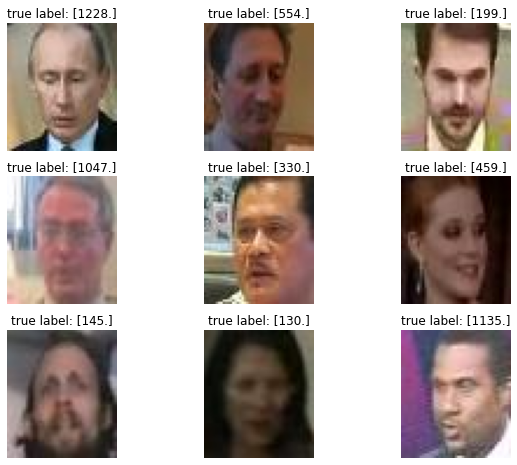

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [ ]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_validation_data)

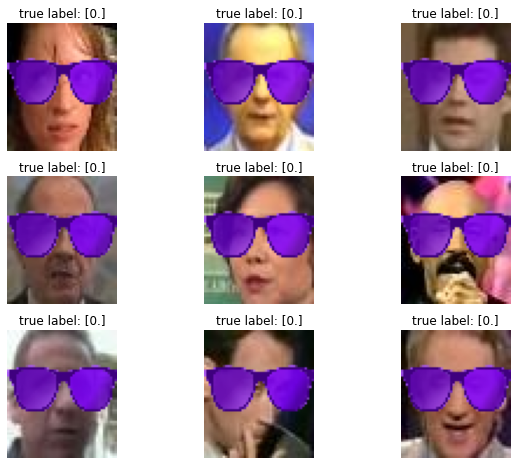

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

**Prune defense**

Pruning the model.

1.   First, the activation of the last pooling layer (last_pool) is checked.
2.   Second, Channels should be removed in decreasing order of average
activation values over the entire validation set


In [ ]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_validation_data)
bd_x_test, bd_y_test = data_loader(poisoned_validation_data)

With normal Colab it runs only till 80% or 47/60

So, I have taken Google Colab Pro for this

In [ ]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


  2%|▏         | 1/60 [00:10<09:51, 10.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  3%|▎         | 2/60 [00:19<09:38,  9.97s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  5%|▌         | 3/60 [00:29<09:27,  9.96s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  7%|▋         | 4/60 [00:39<09:00,  9.65s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  8%|▊         | 5/60 [00:48<08:40,  9.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


 10%|█         | 6/60 [00:57<08:25,  9.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 12%|█▏        | 7/60 [01:06<08:12,  9.29s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 13%|█▎        | 8/60 [01:15<07:59,  9.22s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 15%|█▌        | 9/60 [01:24<07:46,  9.15s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 17%|█▋        | 10/60 [01:34<07:48,  9.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 18%|█▊        | 11/60 [01:43<07:34,  9.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 20%|██        | 12/60 [01:52<07:26,  9.30s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 22%|██▏       | 13/60 [02:02<07:26,  9.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 23%|██▎       | 14/60 [02:12<07:22,  9.61s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 25%|██▌       | 15/60 [02:21<07:06,  9.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 27%|██▋       | 16/60 [02:31<07:03,  9.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 28%|██▊       | 17/60 [02:41<06:55,  9.67s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 30%|███       | 18/60 [02:50<06:42,  9.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49


 32%|███▏      | 19/60 [03:00<06:28,  9.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 33%|███▎      | 20/60 [03:10<06:23,  9.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 35%|███▌      | 21/60 [03:19<06:17,  9.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 37%|███▋      | 22/60 [03:29<06:02,  9.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 38%|███▊      | 23/60 [03:39<05:57,  9.66s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 40%|████      | 24/60 [03:48<05:50,  9.74s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 42%|████▏     | 25/60 [03:58<05:37,  9.64s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 43%|████▎     | 26/60 [04:07<05:25,  9.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 45%|████▌     | 27/60 [04:17<05:14,  9.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 47%|████▋     | 28/60 [04:26<05:03,  9.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 48%|████▊     | 29/60 [04:35<04:52,  9.42s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 50%|█████     | 30/60 [04:45<04:41,  9.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 52%|█████▏    | 31/60 [04:55<04:36,  9.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 53%|█████▎    | 32/60 [05:04<04:24,  9.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 55%|█████▌    | 33/60 [05:13<04:14,  9.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 57%|█████▋    | 34/60 [05:24<04:14,  9.80s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 58%|█████▊    | 35/60 [05:33<04:00,  9.63s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 60%|██████    | 36/60 [05:42<03:47,  9.49s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 62%|██████▏   | 37/60 [05:52<03:36,  9.40s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 63%|██████▎   | 38/60 [06:01<03:30,  9.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 65%|██████▌   | 39/60 [06:11<03:23,  9.70s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 67%|██████▋   | 40/60 [06:21<03:11,  9.57s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 68%|██████▊   | 41/60 [06:30<02:59,  9.44s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 70%|███████   | 42/60 [06:40<02:52,  9.58s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 72%|███████▏  | 43/60 [06:49<02:40,  9.44s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 73%|███████▎  | 44/60 [06:59<02:33,  9.58s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
The accuracy drops at least 2%, saved the model


 75%|███████▌  | 45/60 [07:08<02:21,  9.46s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 77%|███████▋  | 46/60 [07:18<02:14,  9.59s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 78%|███████▊  | 47/60 [07:28<02:05,  9.68s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
The accuracy drops at least 4%, saved the model


 80%|████████  | 48/60 [07:38<01:56,  9.75s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 82%|████████▏ | 49/60 [07:48<01:47,  9.80s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 83%|████████▎ | 50/60 [07:57<01:36,  9.62s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 85%|████████▌ | 51/60 [08:06<01:25,  9.47s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
The accuracy drops at least 10%, saved the model


 87%|████████▋ | 52/60 [08:17<01:19,  9.95s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 88%|████████▊ | 53/60 [08:26<01:08,  9.81s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10


 90%|█████████ | 54/60 [08:36<00:58,  9.67s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 92%|█████████▏| 55/60 [08:46<00:48,  9.78s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 93%|█████████▎| 56/60 [08:56<00:39,  9.83s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18


 95%|█████████▌| 57/60 [09:05<00:29,  9.69s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 97%|█████████▋| 58/60 [09:15<00:19,  9.59s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


 98%|█████████▊| 59/60 [09:24<00:09,  9.51s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


100%|██████████| 60/60 [09:34<00:00,  9.57s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [ ]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

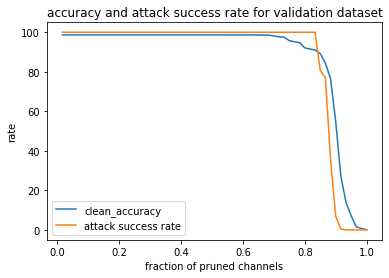

In [ ]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [ ]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combining the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *goodnet*. If the preditions from $B$ and $B'$ are the same then the *goodnet* will output the predition.

In [ ]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [ ]:
test_data = '/content/drive/MyDrive/MLHW/cl/test.h5'
poisoned_test_data = '/content/drive/MyDrive/MLHW/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [ ]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [ ]:
x_test_data, y_test_data = data_loader(test_data)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data)

In [ ]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [ ]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

### Evaluating on the test dataset

In [ ]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

2% drops model, the clean test data Classification accuracy: 95.90023382696803
2% drops model, Attack Success Rate: 100.0
4% drops model, the clean test data classification accuracy: 92.29150428682775
4% drops model, Attack Success Rate: 99.98441153546376
10% drops model, the clean test data classification accuracy: 84.54403741231489
10% drops model, Attack Success Rate: 77.20966484801247


### Summarizing the fixed models

In [ ]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


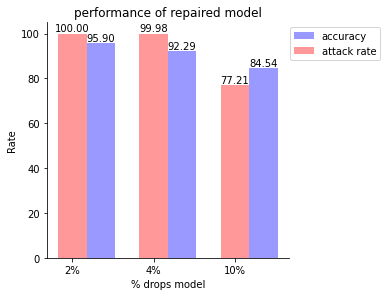

In [ ]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

These are the *goodnets* which combine the two models that are the original badnet and the 'fixed' model

In [ ]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [ ]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


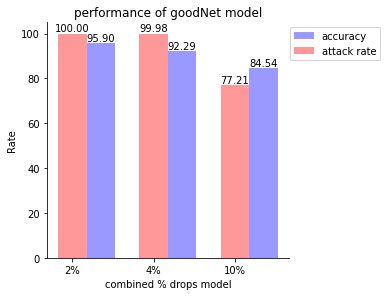

In [ ]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

---